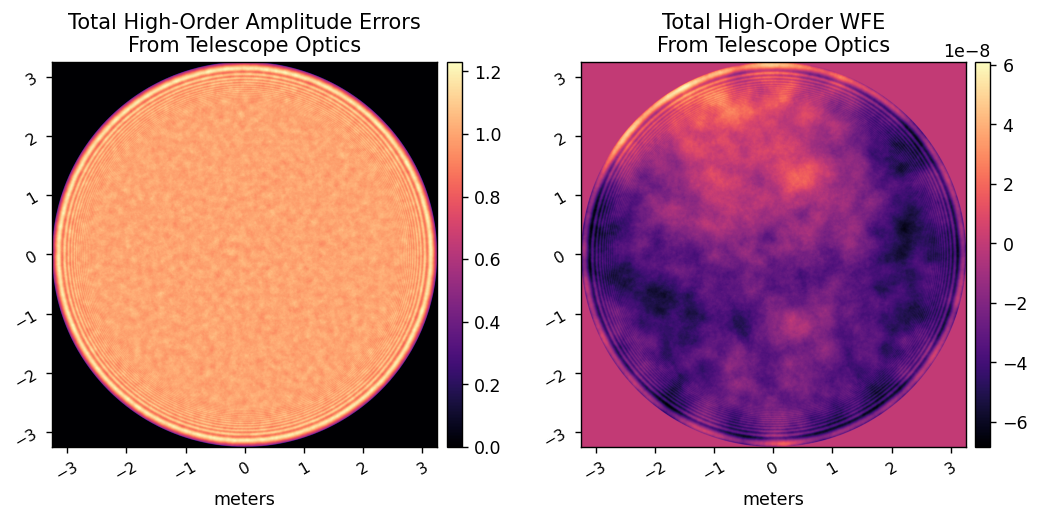

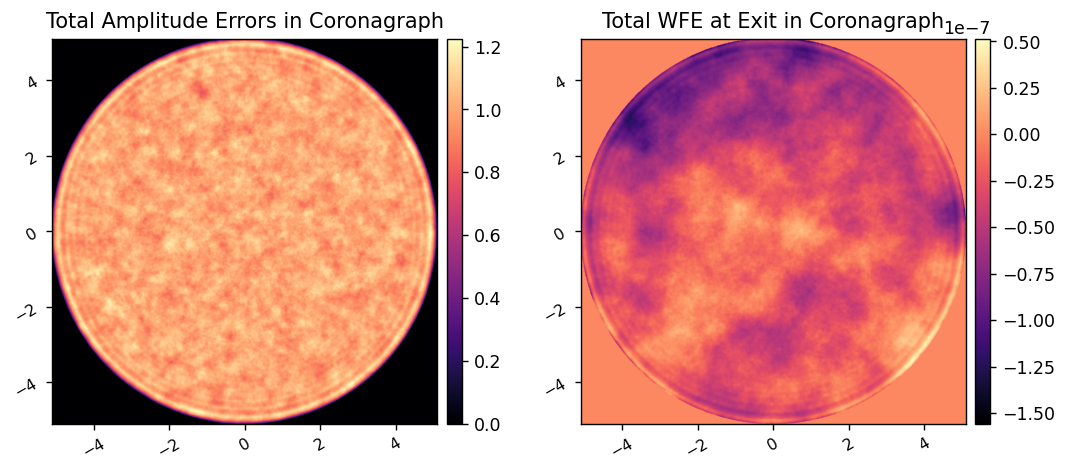

In [5]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys

poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from pop_models import fresnel_coro_poppy, fraunhofer_coro_poppy, agpm, utils
from pop_models.math_module import ensure_np_array

def reload_all():
        reload(fresnel_coro_poppy)
        reload(fraunhofer_coro_poppy)
        reload(agpm)

import lina
from lina.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam *focal_ratio

# Load in the OTE WFE for the full model of the coronagraph
ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 
        'Total High-Order Amplitude Errors\nFrom Telescope Optics', 'Total High-Order WFE\nFrom Telescope Optics', 
#         pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix),
        pxscl=6.5/wfe.shape[1], xlabel='meters',
       )

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('phase-retrieval-data/post_fpm_pupil_wfe.fits')
coro_wfe = np.fliplr(wfe_fits[0].data)
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'Total Amplitude Errors in Coronagraph', 'Total WFE at Exit in Coronagraph',
        pxscl=CORO_WFE.pixelscale.to(u.mm/u.pix))

0.0002178080140498601


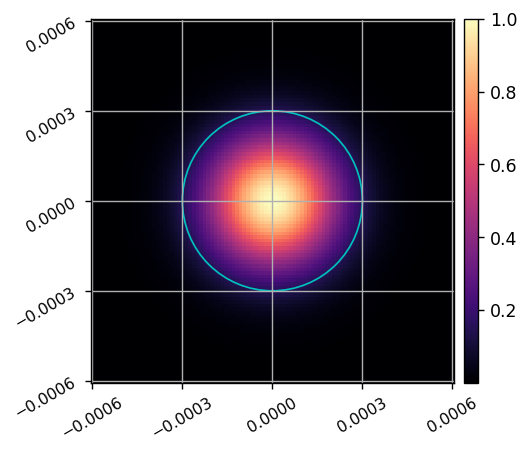

In [6]:
from importlib import reload
from pop_models import dm
reload(dm)
inf_fun, sampling = dm.make_gaussian_inf_fun(coupling=0.15, plot=True)

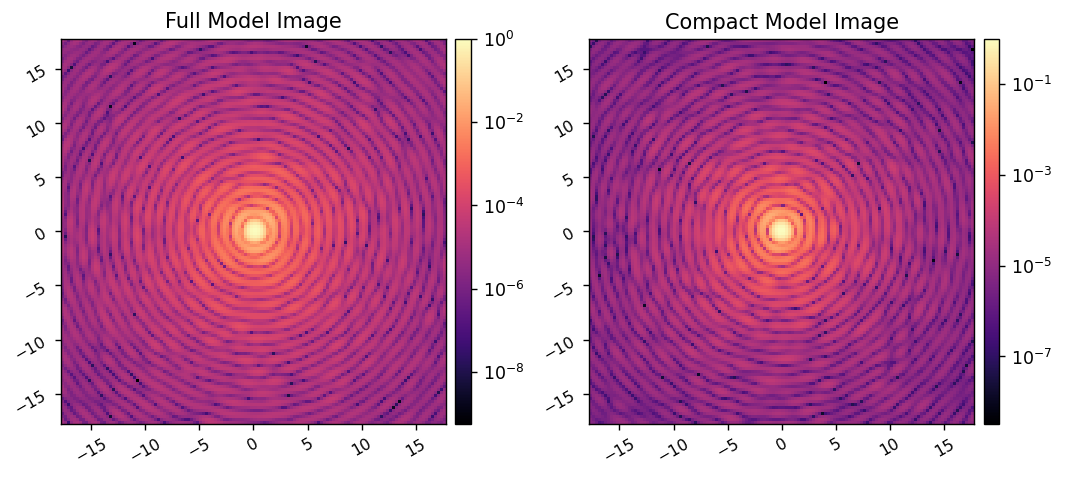

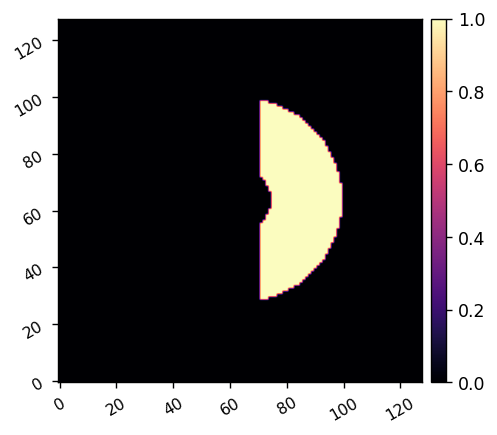

In [7]:
reload_all()

coro = fresnel_coro_poppy.CORO()
coro.npix = 512
coro.oversample = 8
coro.npsf = 128
coro.use_opds = True
coro.OTEWFE = OTE_WFE

model = fraunhofer_coro_poppy.CORO()
model.npix = 512
model.oversample = 8
model.npsf = 128
model.RETRIEVED = CORO_WFE

coro.im_norm = coro.snap().max()
model.im_norm = model.snap().max()

ref_psf = coro.snap()
model_psf = model.snap()

imshow2(ref_psf, model_psf, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=coro.psf_pixelscale_lamD, pxscl2=model.psf_pixelscale_lamD)

reload(lina.utils)
iwa = 3
owa = 10
edge = 2
control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0, plot=True)

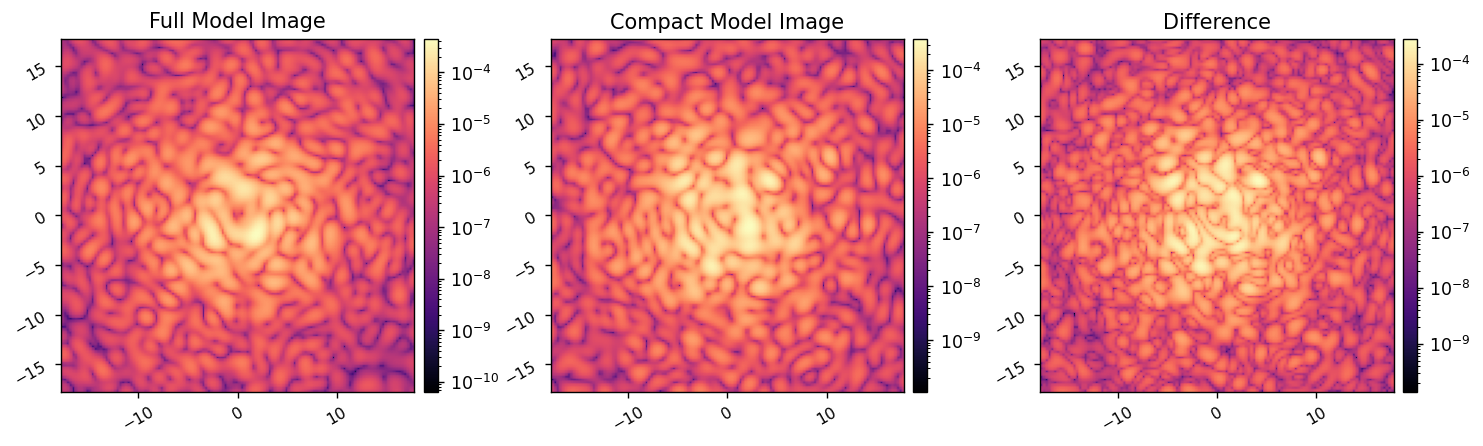

In [8]:
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
vortex_model = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop = poppy.CircularAperture(radius=lyot_diam/2)
lyot_stop_model = poppy.CircularAperture(radius=lyot_diam/2 / focal_ratio)

coro.FPM = vortex
coro.LYOT = lyot_stop

model.FPM = vortex_model
model.LYOT = lyot_stop_model

ref_im = coro.snap()
model_im = model.snap()

imshow3(ref_im, model_im, xp.abs(ref_im-model_im),
        'Full Model Image', 'Compact Model Image', 'Difference',
        lognorm1=True, lognorm2=True, lognorm3=True,
        pxscl=coro.psf_pixelscale_lamD)

In [9]:
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)
poke_amp = 1e-9

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=161.486 sec.
Jacobian built in 161.486 sec


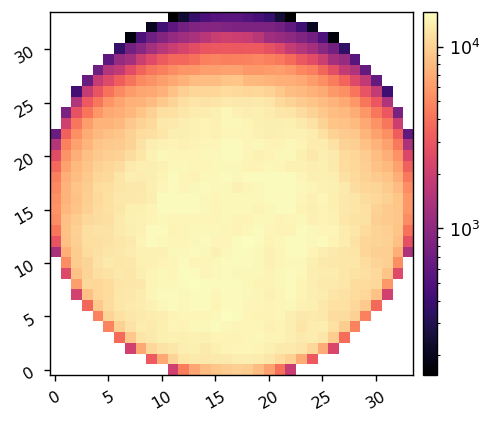

In [10]:
jac = lina.efc.build_jacobian(model, poke_modes, poke_amp, control_mask, plot=True)


In [14]:
utils.save_fits('jac_20231006.fits', jac)

Saved data to:  jac_20231006.fits


In [15]:
jac = xp.array(fits.getdata('jac_20231006.fits'))

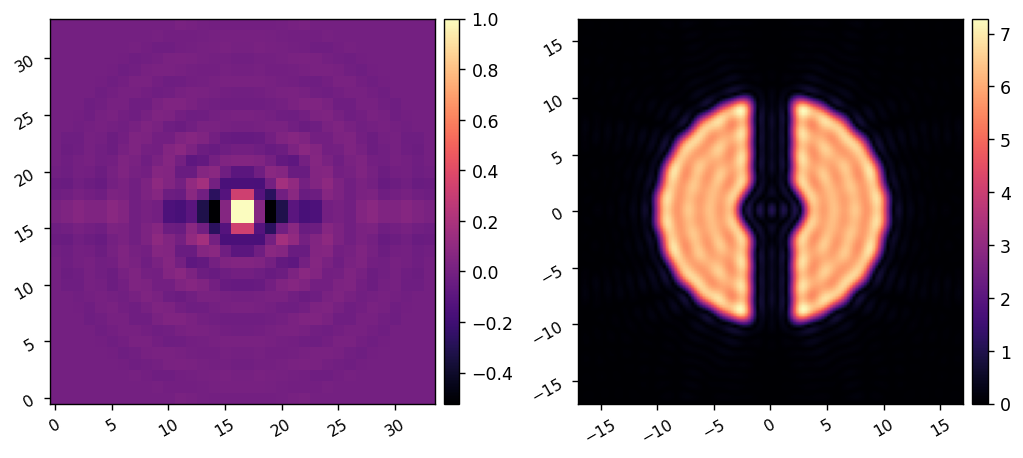

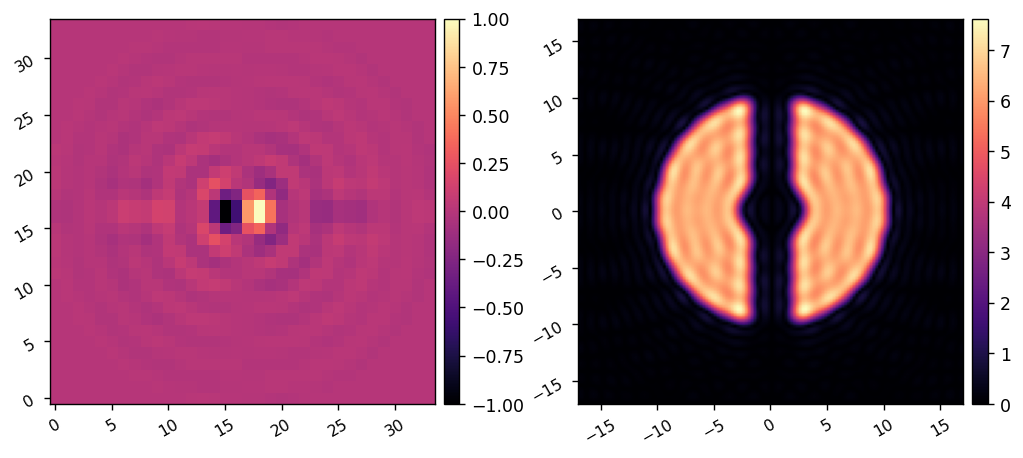

In [43]:
reload(lina.utils)
Npairs = 2

probe_amp = 2e-8

probe_radius = 14
probe_offset = (0,0)

probe_modes = lina.utils.create_fourier_probes(coro, control_mask, fourier_sampling=0.2, 
                                               shift=[probe_offset, probe_offset], 
                                               nprobes=2, 
                                                plot=True, calc_responses=True)
probes = probe_amp * probe_modes

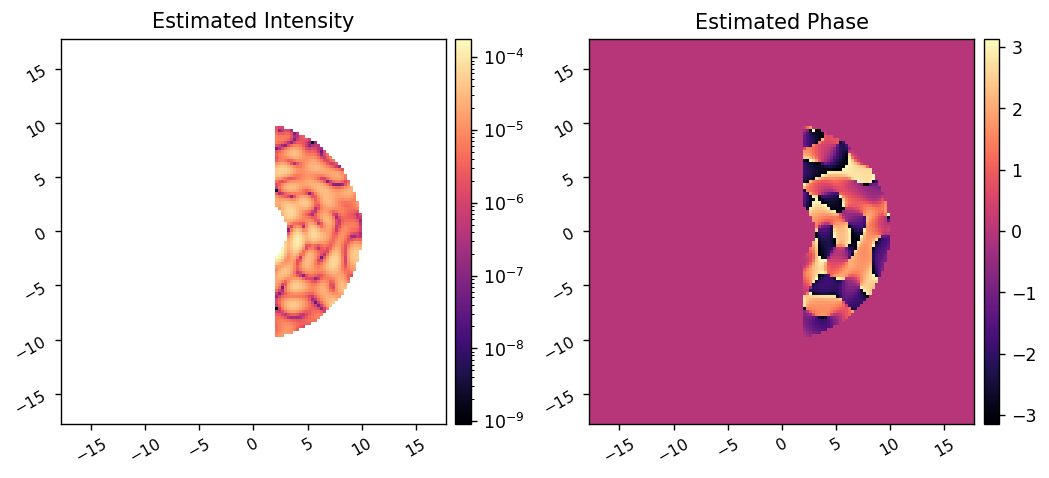

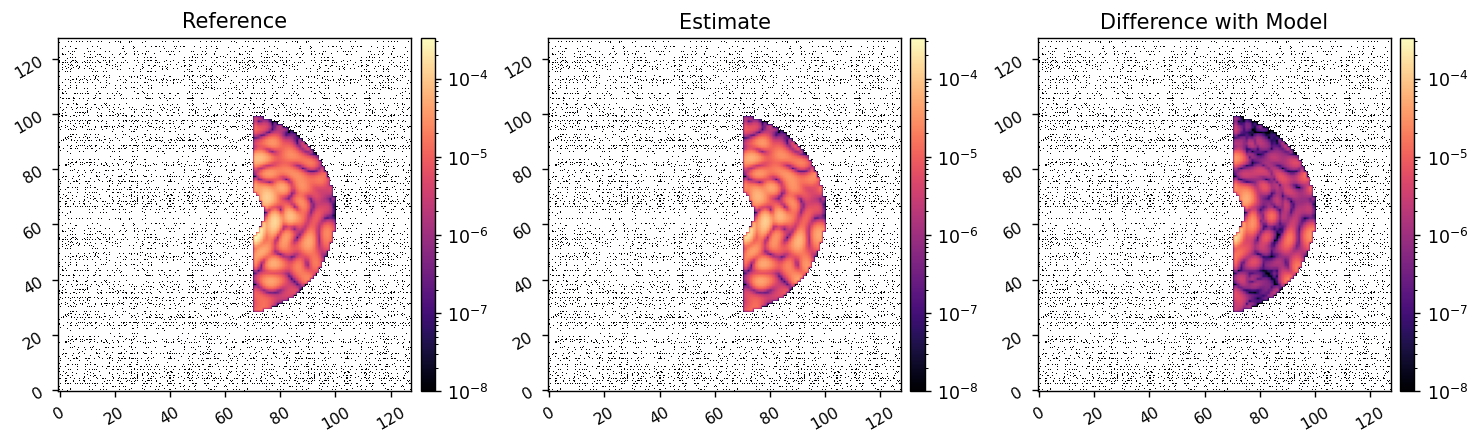

In [44]:
reload(lina.pwp)
coro.reset_dm()
E_est = lina.pwp.run_pwp_bp(coro, control_mask, probes, use='model', model=model, 
                        #     plot=True,
                            plot_est=True)
I_est = np.abs(E_est)**2
P_est = np.angle(E_est)

diff = ref_im*control_mask - I_est
vmax = xp.max(xp.concatenate([ref_im*control_mask, I_est]))
imshow3(ref_im*control_mask, I_est, xp.abs(diff),
        'Reference', 'Estimate', 'Difference with Model',
        lognorm=True, 
        vmax1=vmax, vmax2=vmax, vmax3=vmax,
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

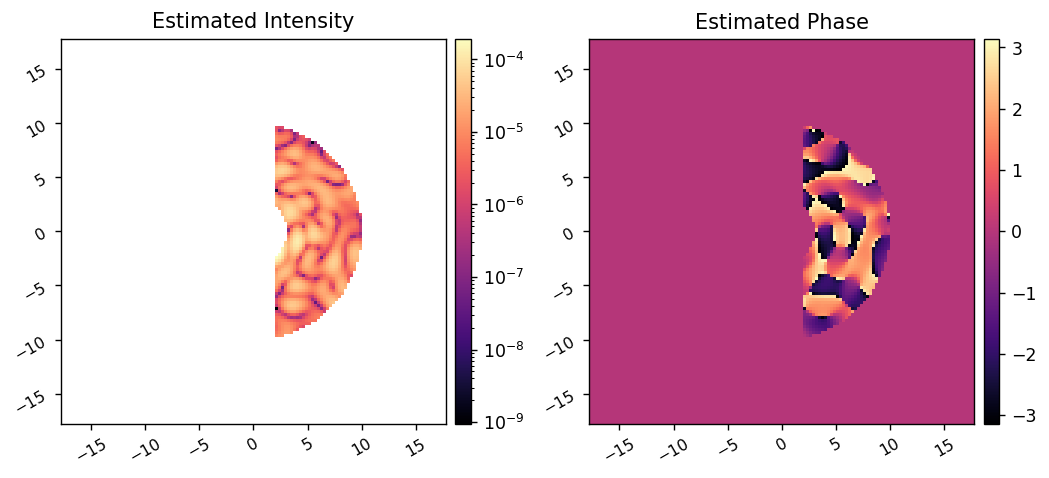

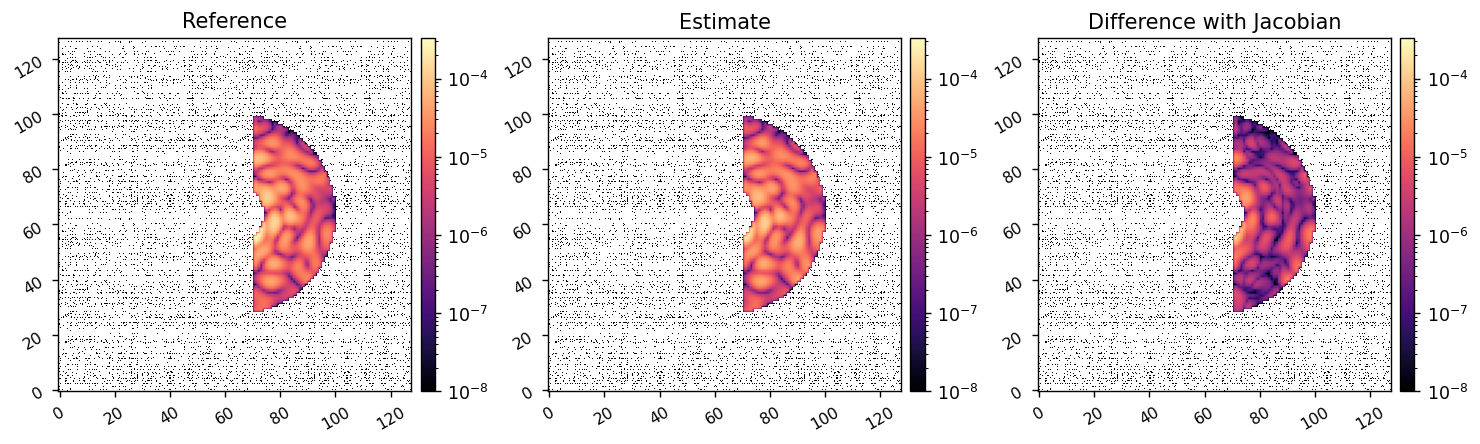

In [45]:
reload(lina.pwp)
coro.reset_dm()
E_est = lina.pwp.run_pwp_bp(coro, control_mask, probes, use='jacobian', jacobian=jac, 
                        #     plot=True,
                            plot_est=True)
I_est = np.abs(E_est)**2
P_est = np.angle(E_est)

diff = ref_im*control_mask - I_est
vmax = xp.max(xp.concatenate([ref_im*control_mask, I_est]))
imshow3(ref_im*control_mask, I_est, xp.abs(diff),
        'Reference', 'Estimate', 'Difference with Jacobian',
        lognorm=True, 
        vmax1=vmax, vmax2=vmax, vmax3=vmax,
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

In [46]:
coro.reset_dm()
model.reset_dm()

images = xp.array([ref_im])
estimates = xp.array([E_est])
dm_commands = xp.array([coro.get_dm()])

In [50]:
reg = 1e-2
# control_matrix = lina.utils.TikhonovInverse(jac, rcond=reg)
control_matrix = lina.utils.beta_reg(jac, -2)

In [48]:
reload(lina)
probe_amp = 1e-8

pwp_fun = lina.pwp.run_pwp_bp
pwp_params = {
    'probes':probe_amp*probe_modes,
    'use':'jacobian',
    'jacobian':jac,
    'plot_est':True,
}



Beginning closed-loop EFC simulation.
Max singular value squared:	 2236654514822.147
alpha^2:			 358690673233.85736
	Running iteration 6/10.


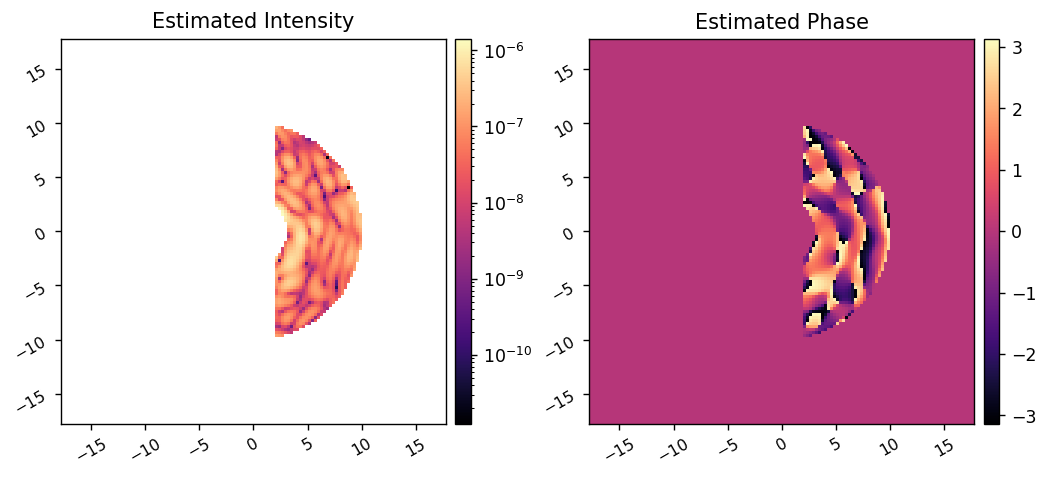

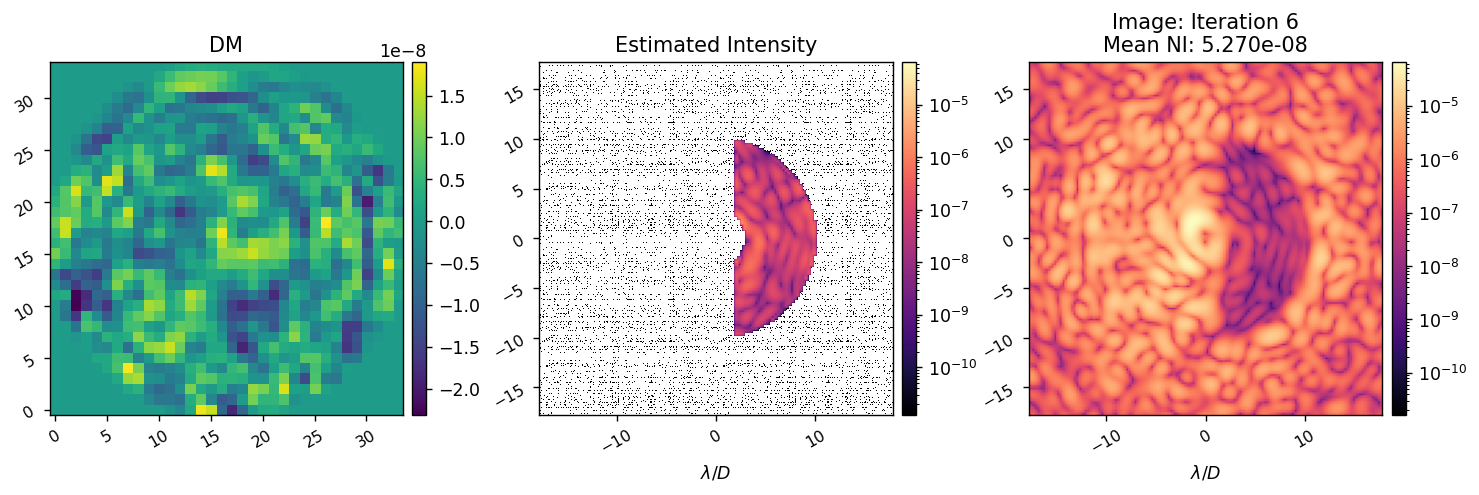

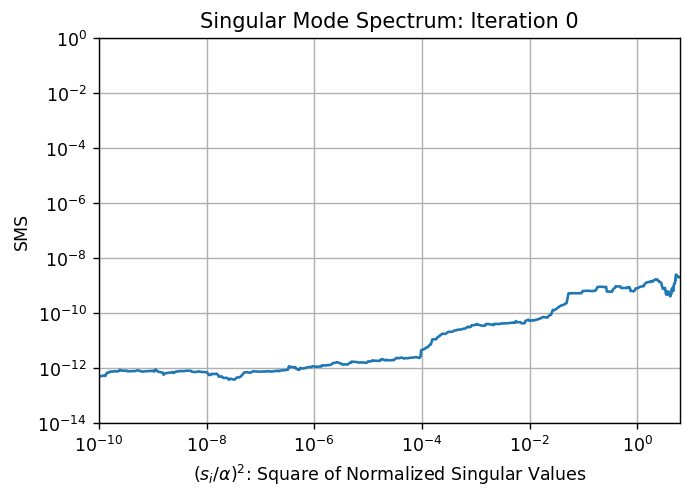

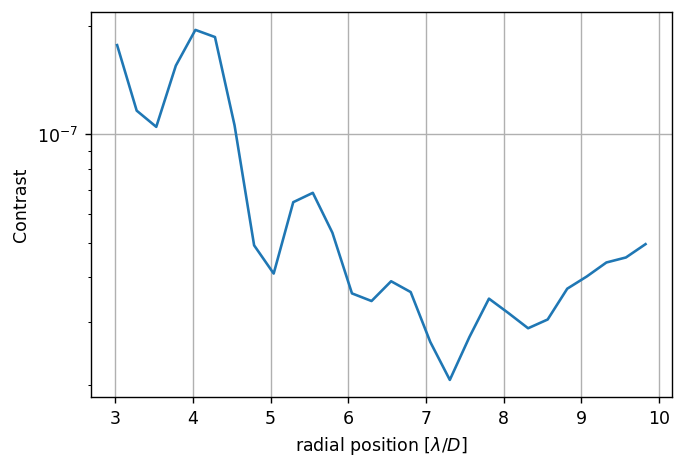

	Running iteration 7/10.


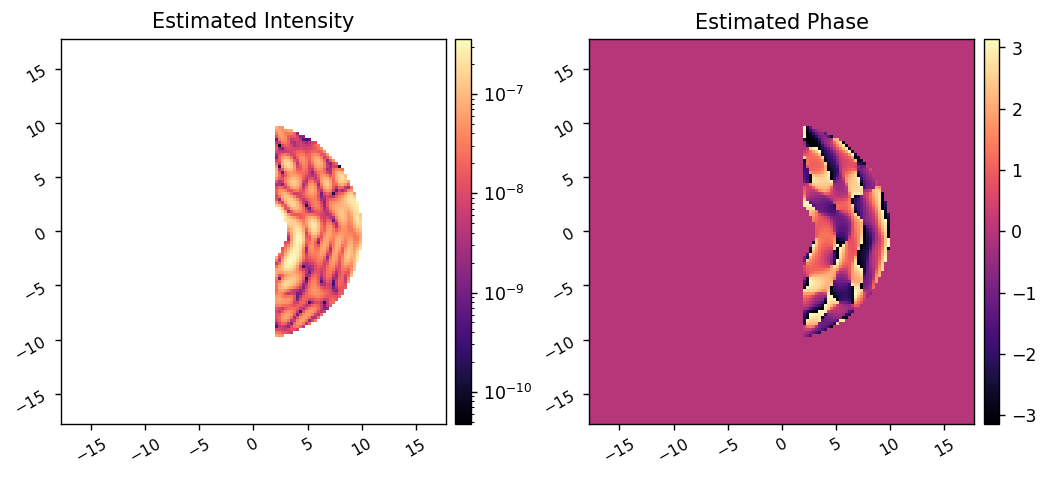

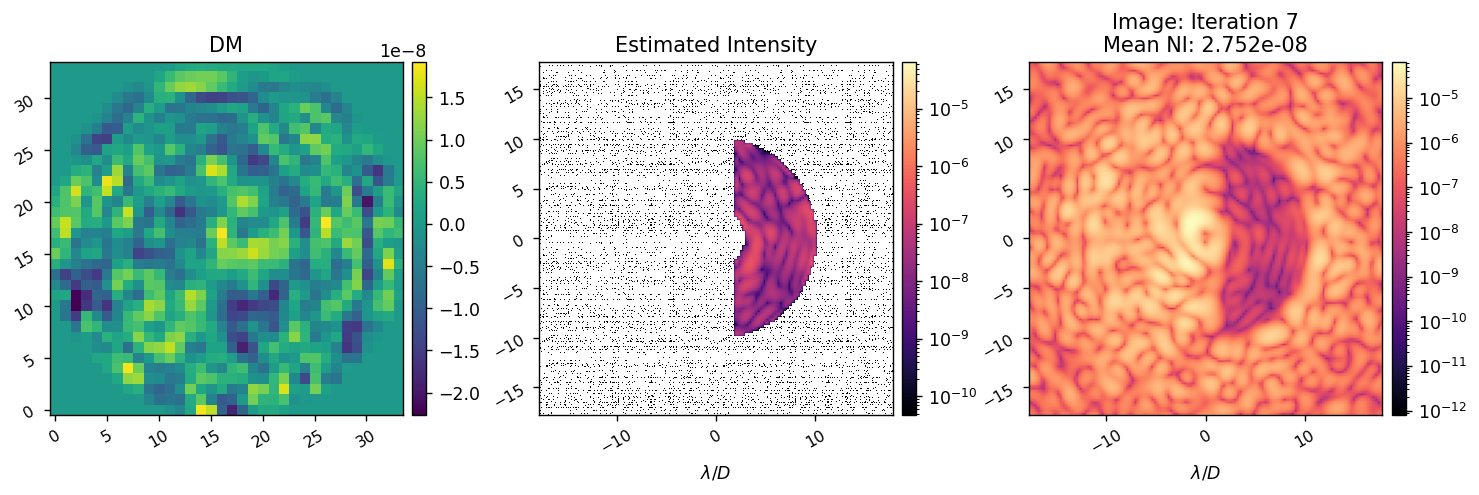

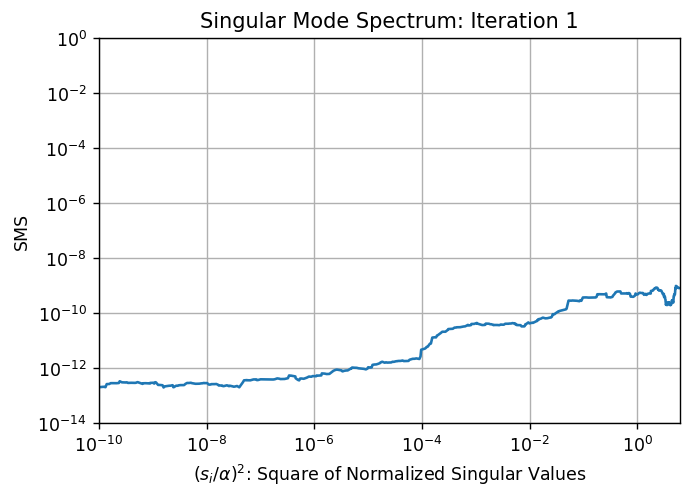

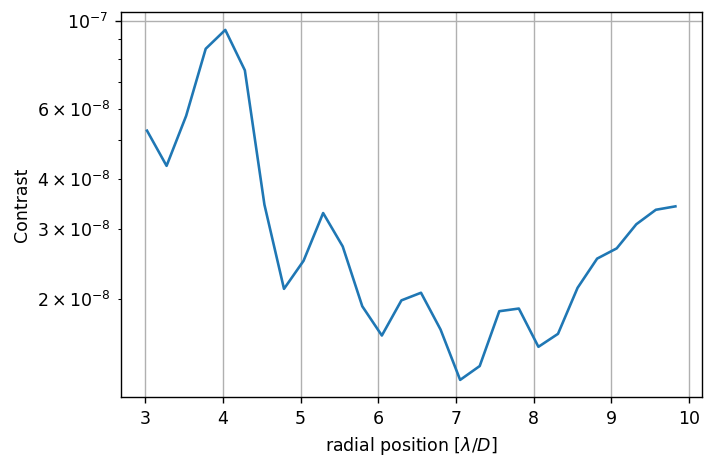

	Running iteration 8/10.


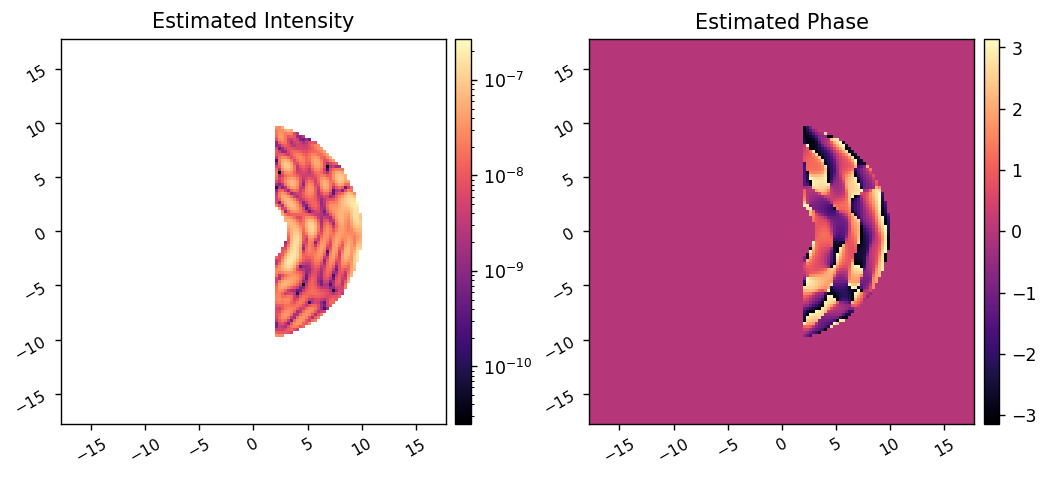

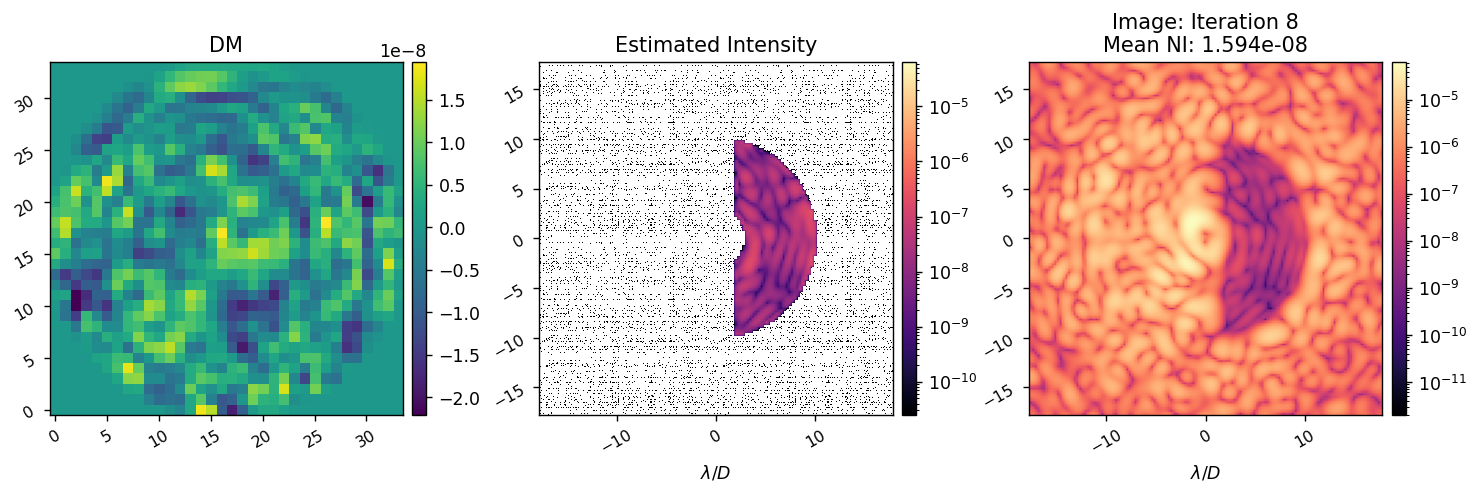

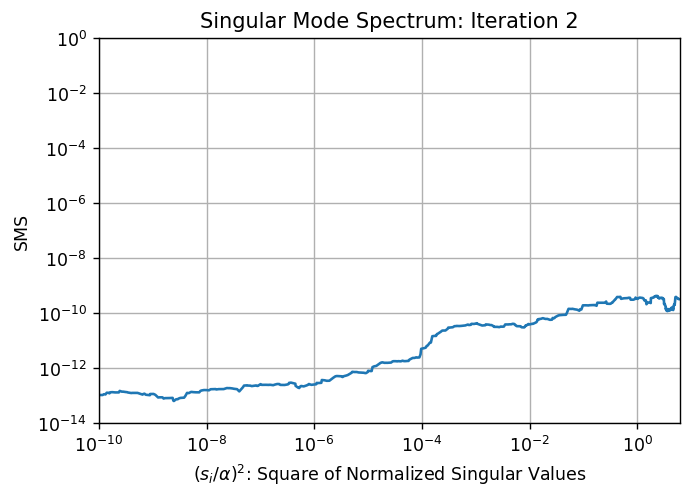

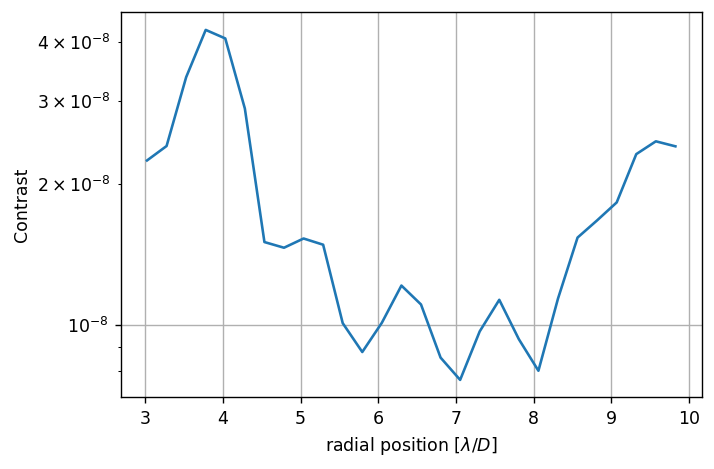

	Running iteration 9/10.


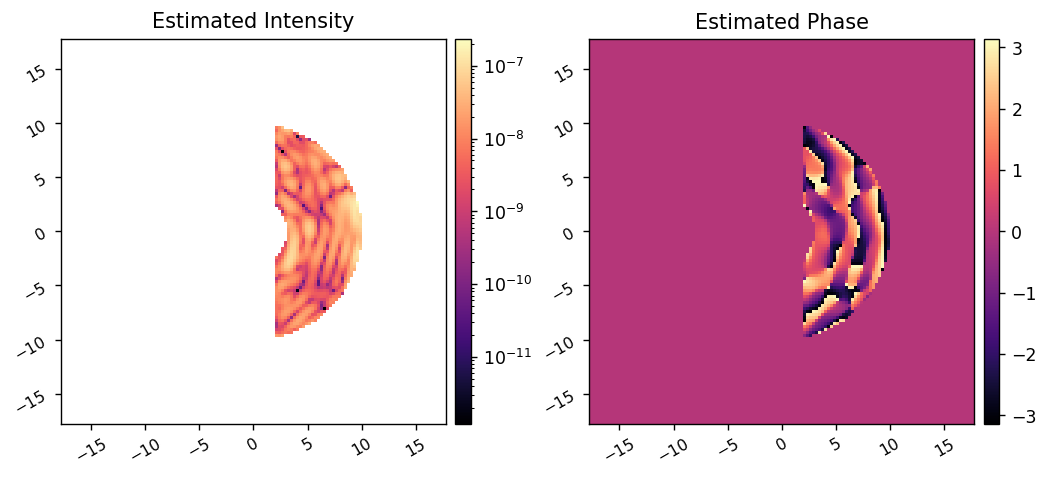

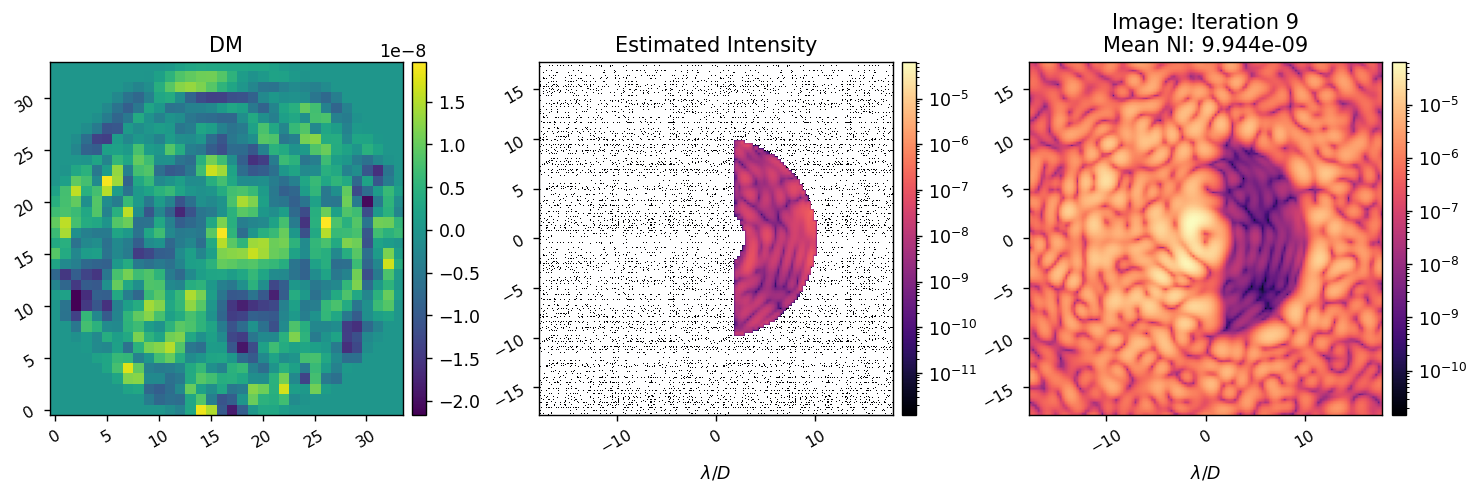

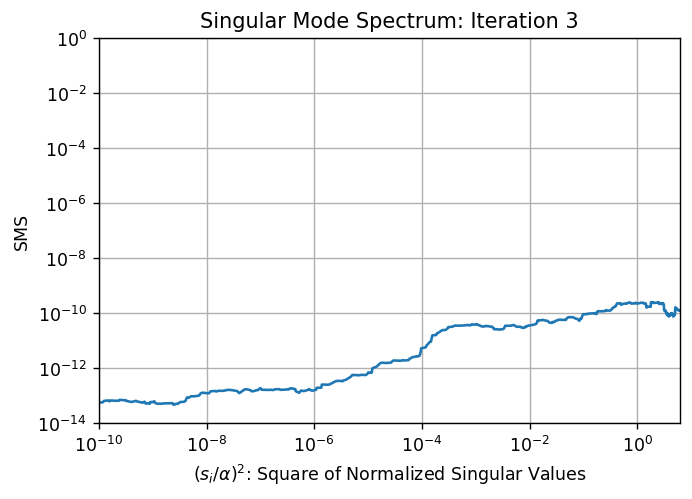

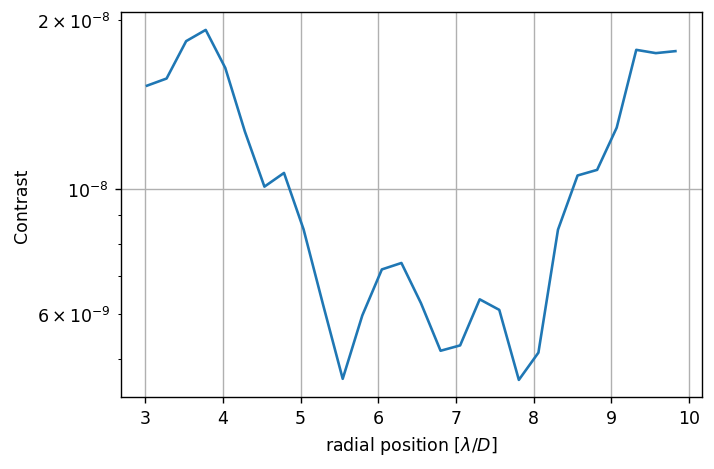

	Running iteration 10/10.


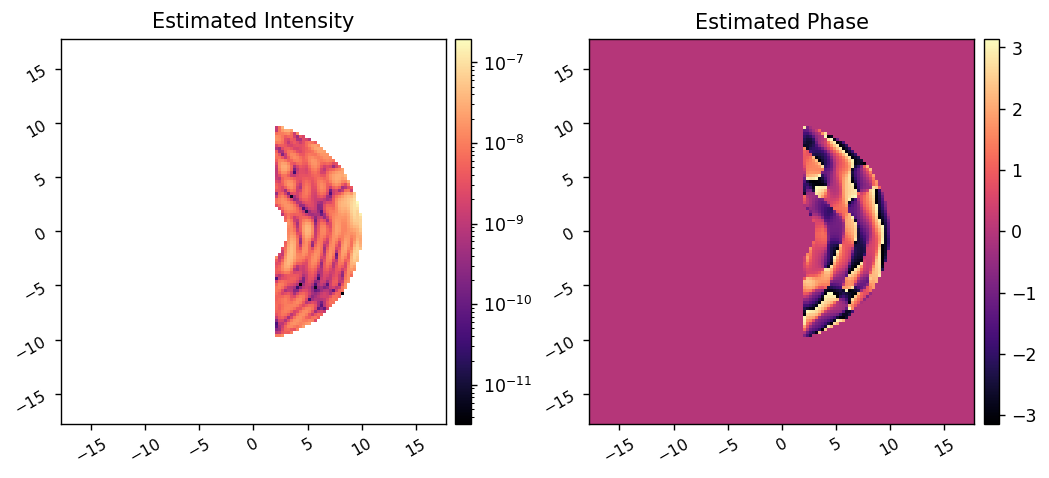

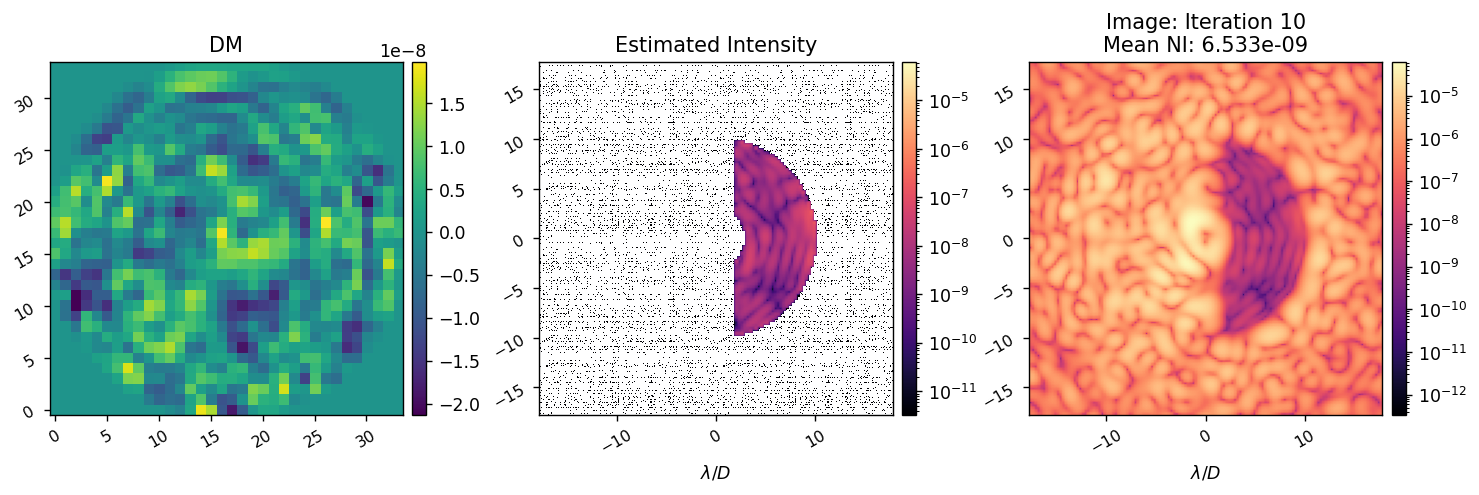

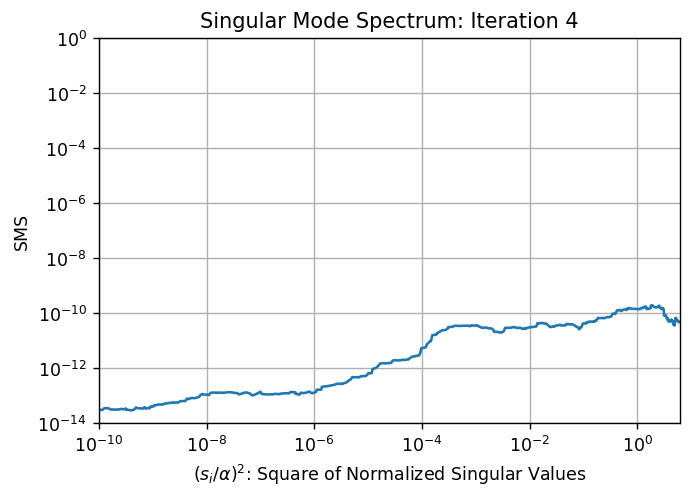

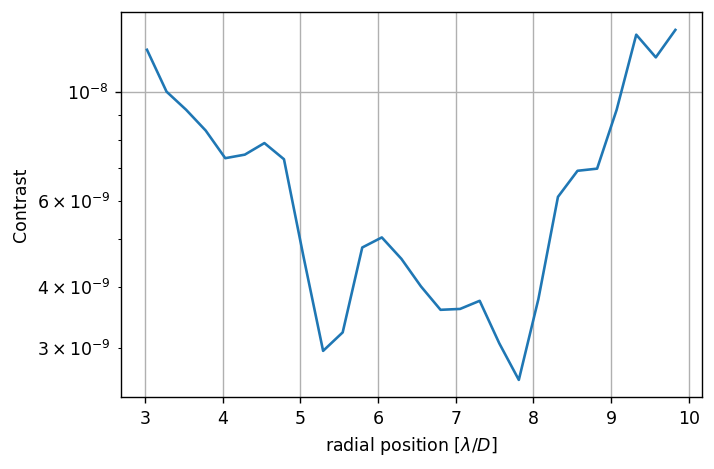

EFC completed in 32.799 sec.


In [51]:
reload(lina.efc)
images, estimates, dm_commands = lina.efc.run_efc_pwp(coro, 
                                                    pwp_fun, pwp_params,
                                                    jac,
                                                    poke_modes,
                                                    control_matrix, 
                                                    control_mask, 
                                                    loop_gain=0.5,
                                                    iterations=5,
                                                    plot_all=True,
                                                    plot_sms=True,
                                                    plot_radial_contrast=True,
                                                    old_images=images,
                                                    old_estimates=estimates,
                                                    old_dm_commands=dm_commands,
                                                    )

In [41]:
import cstruct
import serial

import io
import json
memfile = io.BytesIO()
np.save(memfile, ensure_np_array(ref_im))

serialized = memfile.getvalue()
serialized_as_json = json.dumps(serialized.decode('latin-1'))



In [ ]:
board = serial.Serial(port=None, baudrate=9600)
board.write()

bytearray

In [ ]:
def send_serial(data, port, baudrate=9600):
    # make sure data is a flattened vector
    data = ensure_np_array(data).flatten()
    byte_array = bytearray(data)
    # https://stackoverflow.com/questions/56134392/sending-a-numpy-array-to-arduino-via-serial
    board = serial.Serial(port=port, baudrate=baudrate)
    board.write(byte_array)

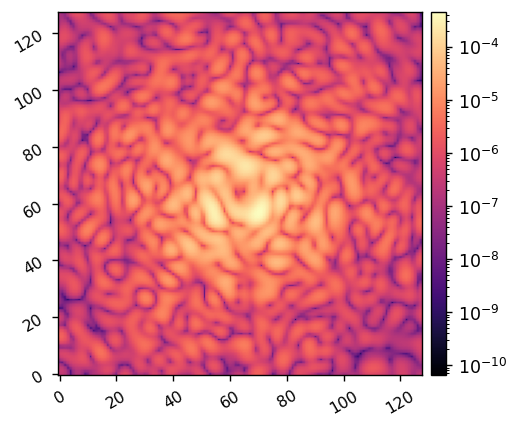

In [54]:
data = bytearray(ensure_np_array(ref_im).flatten())
a = np.frombuffer(data, dtype=np.float64)
imshow1(a.reshape(model.npsf, model.npsf), lognorm=True)